In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma, factorial

STARTING_RANGE_PARAMETER = 0.1 # In [fm^-2]
ENDING_RANGE_PARAMETER = 25
BETA = 0.0000001 # In [fm^-2], can be edited to get a better fit for a realistic density distrbution.
REDUCED_MASS = 935 * 10/11 # In [Mev / c^2], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 20 # Determines the number of gaussians we expand our wave function to

V_LS = 21.0 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

CENTRAL_POTENTIAL_PARAMETERS = [0.1, 0.151991, 0.231013, 0.351119, 0.53367, 0.811131, 1.23285,
                                1.87382, 2.84804, 4.32876, 6.57933, 10.]

CENTRAL_MIXING_COEFFICIENTS = [0.0558247,0.214443,2.42773,-0.724055,-2.17761,1.02031,0.819031,-0.96538,0.197094,0.3221,-0.296652,0.093208]

SPIN_ORBIT_POTENTIAL_PARAMETERS = [4.16493, 2.843, 1.941, 1.325, 0.905, 0.618, 0.422, 0.288, 0.196, 0.134, 0.0916, 0.0625]

SPIN_ORBIT_MIXING_COEFFICIENTS = [0.273, -1.307, 3.305, -5.657, 6.565, -3.368, -2.437, 2.638, 0.719, 0.235, 0.0186, 0.00108]


We now define our normalised single gaussian wavefunction (note we do not have an orthonormal basis), our Woods-Saxon potential, our Woods-Saxon with spin orbit coupling, our single gaussian potential, and its derivative, and a full expresion for the spin orbit coupling with the gaussian basis.

In [6]:
def gaussian_wavefunction(radius, range_parameter, orb_ang_momentum):
    normalisation = (2**(-2.5 - orb_ang_momentum) * (range_parameter)**(3 + 2 * orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    return normalisation * radius**(orb_ang_momentum) * np.exp(- (radius / range_parameter)**2)

def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : array like, the radius to evaluate the potential at
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    array like , potential evaluated at r
    """
    return c * np.exp(-β * (r)**2)

def single_gaussian_potential_gradient(r, c, β):
    return c * (-2 * β) * np.exp(-β * (r)**2)

def gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters):
    V_0 = -11.39 * (-1)**orb_ang_momentum - 51.13 # Defines V_0 for odd and even l states
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_function(radius, central_mixing_coefficients[i], central_potential_parameters[i])
    return V_0 * potential

def gaussian_expanded_potential_gradient(radius, orb_ang_momentum, mixing_coefficients, potential_parameters):
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_derivative(radius, mixing_coefficients[i], potential_parameters[i])
    return V_0 * potential

def spin_orbit_term(tot_ang_momentum, orb_ang_momentum): # Do we need hbar?
    return 0.5 * (tot_ang_momentum * (tot_ang_momentum + 1) - orb_ang_momentum * (orb_ang_momentum + 1) - 0.75)

def complete_gaussian_potential(radius, tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters,
                                spin_orbit_mixing_coefficients, spin_orbit_potential_parameters, vls=V_LS):
    return gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters
                                      ) - vls * spin_orbit_term(tot_ang_momentum, orb_ang_momentum) * gaussian_expanded_potential_gradient(
        radius, orb_ang_momentum, spin_orbit_mixing_coefficients, spin_orbit_potential_parameters)
        

def complete_woods_saxon_potential(radius, tot_ang_moment, orb_ang_moment, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

We have used mathmatica to get a set of analytical expressions for our matrix elements, defined below. We have now also included the spin orbit term in the potential matrix element

In [12]:
def overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return ((2 * range_param_i * range_param_j) / (range_param_i**2 + range_param_j**2))**(1.5 + orb_ang_momentum)


def potential_matrix_element(tot_ang_momentum, orb_ang_momentum, range_param_i, range_param_j, central_potential_mixing_coefficient,
                             central_potential_param, spin_orbit_potential_mixing_coefficient, spin_orbit_potential_param, vls=V_LS):
    V_0 = -11.39 * (-1)**orb_ang_momentum - 51.13 # Defines V_0 for odd and even l states
    central_term = central_potential_mixing_coefficient * V_0 * (
        central_potential_param + range_param_i**(-2) + range_param_j**(-2))**(-1.5 - orb_ang_momentum)
    spin_orbit_potential_term = -2 * spin_orbit_potential_mixing_coefficient * vls * spin_orbit_term(
        tot_ang_momentum, orb_ang_momentum) * spin_orbit_potential_param * (
        spin_orbit_potential_param + range_param_i**(-2) + range_param_j**(-2))**(-1.5 - orb_ang_momentum)
    return (2 / (range_param_i * range_param_j))**(1.5 + orb_ang_momentum) * (central_term + spin_orbit_potential_term)

def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, μ=REDUCED_MASS):
    term_1 = 2 * orb_ang_momentum + 3
    term_2 = (range_param_i * range_param_j)**(-3.5 - orb_ang_momentum)
    term_3 = ((2 * range_param_i**2 * range_param_j**2) / (range_param_i**2 + range_param_j**2))**(2.5 + orb_ang_momentum)

    return (197**2 / (2 * μ)) * term_1 * term_2 * term_3

markdown

In [13]:
def matrix_generation(tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients=CENTRAL_MIXING_COEFFICIENTS,
                      central_potential_parameters=CENTRAL_POTENTIAL_PARAMETERS,
                      spin_orbit_potential_mixing_coefficients=SPIN_ORBIT_MIXING_COEFFICIENTS,
                      spin_orbit_potential_parameters=SPIN_ORBIT_POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size))
    n_matrix = np.zeros(shape=(size, size))

    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            potential_energy_term = 0
            for k in range(len(central_mixing_coefficients)):
                potential_energy_term += potential_matrix_element(tot_ang_momentum, orb_ang_momentum, i_range_parameter,
                                                                  j_range_parameter, central_mixing_coefficients[k],
                                                                  central_potential_parameters[k], spin_orbit_potential_mixing_coefficients[k],
                                                                 spin_orbit_potential_parameters[k])
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            # h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            # ((2 * 10**(np.abs(i - j))) / (1 + 10**(2 * np.abs(i - j))))**(1.5 + orb_ang_momentum)
            # n_matrix[j, i] = n_matrix[i, j]
            # j += 1

    return h_matrix, n_matrix


def next_range_parameter(i, starting_range_parameter=STARTING_RANGE_PARAMETER, ending_range_parameter=ENDING_RANGE_PARAMETER,
                         sum_limit=SUM_LIMIT):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    geometric_progression_number = (ending_range_parameter / starting_range_parameter)**(1 / (sum_limit - 1))
    new_range_parameter = starting_range_parameter * geometric_progression_number**(i)

    return new_range_parameter

s_h_matrix, s_n_matrix = matrix_generation(0.5, 0)
p_one_half_h_matrix, p_one_half_n_matrix = matrix_generation(0.5, 1)

With our matrices found we now calculate the eigenvalues and the groundstate eigenvector, corresponding to the lowest (hence groundstate?) energy.

In [14]:
s_eigenvalues, s_eigenvectors = scipy.linalg.eigh(s_h_matrix, s_n_matrix)
s_overlap_eigenvalues, s_overlap_eigenvectors = scipy.linalg.eigh(s_n_matrix)
s_overlap_matrix_condition_number = np.max(s_overlap_eigenvalues) / np.min(s_overlap_eigenvalues)
print(f"The s 1/2 overlap matrix condition number is", s_overlap_matrix_condition_number)

s0_eigenvector = np.asmatrix(s_eigenvectors[:, 0])
s1_eigenvector = np.asmatrix(s_eigenvectors[:, 1])
print("The S state eigenvalues are", s_eigenvalues)
print("The S1 eigenvector is", s1_eigenvector)

The s 1/2 overlap matrix condition number is 710696.8452283429
The S state eigenvalues are [-3.27294725e+01 -4.95850181e-01  9.80780049e-02  4.26839034e-01
  1.11895756e+00  2.47954243e+00  5.16082663e+00  1.04729397e+01
  2.11116226e+01  4.18459758e+01  8.16132548e+01  1.59634742e+02
  3.09824603e+02  5.88574402e+02  1.09560183e+03  2.01373026e+03
  3.68465780e+03  6.77182191e+03  1.26772736e+04  2.50763975e+04]
The S1 eigenvector is [[ 6.77231198e-05 -3.67069936e-04  1.13957637e-03 -2.77630060e-03
   6.02270828e-03 -1.24603155e-02  2.57374067e-02 -5.60778990e-02
   1.30079846e-01 -2.22500560e-01 -6.58409647e-01  2.52077235e-01
   5.47154788e-02  3.12484253e-01  1.17472675e-01  2.99701093e-01
   1.22964057e-01  1.87343504e-01  4.22339021e-02  2.78308948e-02]]


In [15]:
p_one_half_eigenvalues, p_one_half_eigenvectors = scipy.linalg.eigh(p_one_half_h_matrix, p_one_half_n_matrix)
p_one_half_overlap_eigenvalues, p_one_half_overlap_eigenvectors = scipy.linalg.eigh(p_one_half_n_matrix)
p_one_half_overlap_matrix_condition_number = np.max(p_one_half_overlap_eigenvalues) / np.min(p_one_half_overlap_eigenvalues)
print(f"The P 1/2 overlap matrix condition number is", p_one_half_overlap_matrix_condition_number)

zero_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 0])
one_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 1])
print("The P 1/2 state eigenvalues are", p_one_half_eigenvalues)
print("The P1 eigenvector is", one_p_one_half_eigenvector)

The P 1/2 overlap matrix condition number is 81099.81654068564
The P 1/2 state eigenvalues are [-1.77149092e-01  1.32753410e-01  4.45668758e-01  1.05750382e+00
  2.21002997e+00  4.38439027e+00  8.51204198e+00  1.63369440e+01
  3.10329008e+01  5.82992655e+01  1.09072834e+02  2.04212414e+02
  3.80274255e+02  7.01019149e+02  1.28038736e+03  2.32575042e+03
  4.22221394e+03  7.71134054e+03  1.43438196e+04  2.81332158e+04]
The P1 eigenvector is [[-1.07517654e-05  5.31518960e-05 -1.55124996e-04  3.61644985e-04
  -7.56868016e-04  1.50677589e-03 -2.92374436e-03  5.62196193e-03
  -1.09618300e-02  2.40495043e-02 -6.07616507e-02  4.38403768e-02
  -1.66176740e-01  2.35467947e-01 -4.98023459e-01  8.41994539e-01
  -1.50672987e+00  2.34794308e+00 -3.14629317e+00  2.61613268e+00]]


We now include a method to get the average radius a neutron in a given state will be from the nucleus

In [16]:
def position_operator_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    term_1 = factorial(orb_ang_momentum) * (orb_ang_momentum + 1)
    term_2 = (2 / (range_param_i * range_param_j))**(1.5 + orb_ang_momentum)
    term_3 = ((range_param_i**2 * range_param_j**2) / (range_param_i**2 + range_param_j**2))**(2 + orb_ang_momentum)
    return term_1 * term_2 * term_3

def poisition_operator(orb_ang_momentum, state_eigenvector,size=SUM_LIMIT):
    average_radius = 0
    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            average_radius += state_eigenvector[0, i] * state_eigenvector[0, j] * position_operator_matrix_element(
                orb_ang_momentum, i_range_parameter, j_range_parameter)
    return average_radius

#ground_state_average_radius = poisition_operator(ORBITAL_QUANTUM_NUMBER, ground_state_eigenvector)
#s1_average_radius = poisition_operator(ORBITAL_QUANTUM_NUMBER, s1_eigenvector)
#print(ground_state_average_radius, s1_average_radius)

We now do plotting

In [17]:
def radial_wavefunction(x_values, wavefunction_eigenvector, orbital_quantum_number, sum_limit=SUM_LIMIT):
    """
    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.
    """
    wavefunction_vals = np.zeros(shape=(1, len(x_values)))[0, :]

    for i in range(len(x_values)):
        for j in range(sum_limit):
            range_parameter = next_range_parameter(j)
            wavefunction_vals[i] += (wavefunction_eigenvector[0, j] * gaussian_wavefunction(x_values[i], 
                range_parameter, orbital_quantum_number))
        wavefunction_vals[i] = wavefunction_vals[i]**2
    return wavefunction_vals

C:\Users\faola\AppData\Local\Temp\ipykernel_12340\1035720931.py:36: RuntimeWarning: divide by zero encountered in log
  ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, zero_p_one_half_eigenvector, 1))), label="0P radial wavefunction")
C:\Users\faola\AppData\Local\Temp\ipykernel_12340\1035720931.py:37: RuntimeWarning: divide by zero encountered in log
  ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, one_p_one_half_eigenvector, 1))), label="1P radial wavefunction")


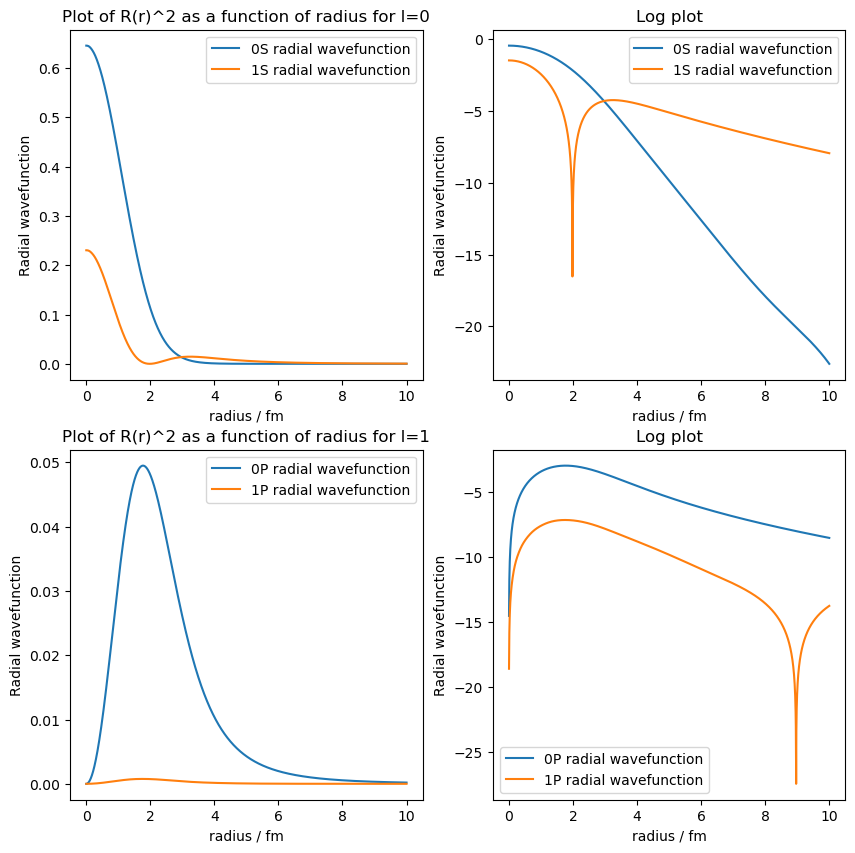

In [19]:
fig = plt.figure(figsize=(10,10))
spec = fig.add_gridspec(ncols=2, nrows=2)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[1, 0])
ax_4 = fig.add_subplot(spec[1, 1])

x_values = np.linspace(0., 10, 3000)
#evaluated_ur_values = reduced_radial_wavefunction(x_values, ground_state_eigenvector, 0)[0]
#print(reduced_radial_wavefunction(x_values))

ax_1.set_title(f'Plot of R(r)^2 as a function of radius for l=0')
ax_1.set_xlabel('radius / fm')
ax_1.set_ylabel('Radial wavefunction')
ax_1.plot(x_values, radial_wavefunction(x_values, s0_eigenvector, 0), label="0S radial wavefunction")
ax_1.plot(x_values, radial_wavefunction(x_values, s1_eigenvector, 0), label="1S radial wavefunction")
ax_1.legend()

ax_2.set_title('Log plot')
ax_2.set_xlabel('radius / fm')
ax_2.set_ylabel('Radial wavefunction')
ax_2.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, s0_eigenvector, 0))), label="0S radial wavefunction")
ax_2.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, s1_eigenvector, 0))), label="1S radial wavefunction")
ax_2.legend()

ax_3.set_title(f'Plot of R(r)^2 as a function of radius for l=1')
ax_3.set_xlabel('radius / fm')
ax_3.set_ylabel('Radial wavefunction')
ax_3.plot(x_values, radial_wavefunction(x_values, zero_p_one_half_eigenvector, 1), label="0P radial wavefunction")
ax_3.plot(x_values, radial_wavefunction(x_values, one_p_one_half_eigenvector, 1), label="1P radial wavefunction")
ax_3.legend()

ax_4.set_title('Log plot')
ax_4.set_xlabel('radius / fm')
ax_4.set_ylabel('Radial wavefunction')
ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, zero_p_one_half_eigenvector, 1))), label="0P radial wavefunction")
ax_4.plot(x_values, np.log(np.abs(radial_wavefunction(x_values, one_p_one_half_eigenvector, 1))), label="1P radial wavefunction")
ax_4.legend()

plt.savefig('s_state_plot.png', dpi=300)
plt.show()